# Advanced CUDA Kernels: Kernel Fusion and Model Patching

The [beginner notebook](demo_4090.ipynb) showed how to download a single kernel and benchmark it. This notebook goes deeper:

1. **Kernel Fusion** — the #1 technique for real speedups: combining multiple operations into one GPU call
2. **RMSNorm** — the normalization layer used in every modern LLM (LLaMA, Mistral, GPT), and why a custom kernel helps
3. **Fused LayerNorm + Linear** — eliminating an entire memory round-trip by merging two layers
4. **Model Patching** — building a realistic transformer block and swapping its internals with optimized kernels, measuring the real impact

This is how production AI inference systems (vLLM, TGI, SGLang) actually use custom kernels.

In [1]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from kernels import get_kernel

# Load both kernel packages from HuggingFace Hub
act_kernel = get_kernel("kernels-community/activation")
norm_kernel = get_kernel("kernels-community/triton-layer-norm")

print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Activation kernel functions: {[f for f in dir(act_kernel) if not f.startswith('_') and f not in ('torch','ops','layers')]}")
print(f"Norm kernel functions: {[f for f in dir(norm_kernel) if not f.startswith('_') and f not in ('torch','ops','layers','Optional','utils')]}")

/home/rob/PythonEnvironments/Kernels/.kernels/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 106377.28it/s]


GPU: NVIDIA GeForce RTX 4090
Activation kernel functions: ['fatrelu_and_mul', 'gelu', 'gelu_and_mul', 'gelu_fast', 'gelu_new', 'gelu_quick', 'gelu_tanh', 'gelu_tanh_and_mul', 'mul_and_silu', 'silu', 'silu_and_mul']
Norm kernel functions: ['layer_norm', 'layer_norm_fn', 'layer_norm_linear_fn', 'rms_norm_fn']


---
## Part 1: Why Kernel Fusion Matters

### The Memory Wall Problem

Your RTX 4090 can do **83 TFLOPS** of float16 math, but can only move data at **1,008 GB/s**. For most AI operations, the GPU finishes the math long before the data arrives — it sits idle, waiting for memory.

Consider what happens when PyTorch runs `SiLU(x) * gate`:

```
Step 1 — SiLU:     Read x from memory → compute SiLU → write result to memory
Step 2 — Multiply:  Read SiLU result from memory → read gate from memory → multiply → write to memory
```

That's **4 memory trips** for 2 operations. Each trip through the 4090's memory takes time.

A **fused kernel** does both in a single GPU call:

```
Fused:  Read x and gate from memory → compute SiLU(x) * gate in registers → write result to memory
```

That's **2 memory trips** — we cut the memory traffic nearly in half. The math is identical; we just stopped writing and re-reading the intermediate result.

Let's prove it.

In [2]:
def benchmark(func, iterations=300, warmup=30):
    """Benchmark a GPU function. Returns average time in milliseconds."""
    for _ in range(warmup):
        func()
    torch.cuda.synchronize()
    start = time.perf_counter()
    for _ in range(iterations):
        func()
    torch.cuda.synchronize()
    return (time.perf_counter() - start) / iterations * 1000

### Demo: Fused SiLU-and-Multiply

**SiLU** (Sigmoid Linear Unit, also called "Swish") is the activation function used in LLaMA, Mistral, and most modern LLMs. In these models, the MLP (feed-forward) block computes:

```
output = SiLU(x_gate) * x_up
```

where `x_gate` and `x_up` are two separate linear projections of the input. The `silu_and_mul` kernel fuses the activation and multiplication into one call.

In [3]:
# Simulate LLaMA MLP dimensions
# LLaMA-7B: hidden=4096, intermediate=11008
# We'll use a batch of 2048 tokens (a realistic inference batch)
batch_tokens = 2048
intermediate_size = 11008

# In the real model, the gate and up projections are concatenated: shape [batch, 2 * intermediate]
# The fused kernel expects this concatenated format and splits internally
x_concat = torch.randn((batch_tokens, 2 * intermediate_size), dtype=torch.float16, device="cuda")
out_fused = torch.empty((batch_tokens, intermediate_size), dtype=torch.float16, device="cuda")

# For the unfused version, we split manually
x_gate = x_concat[:, :intermediate_size].contiguous()
x_up = x_concat[:, intermediate_size:].contiguous()

print(f"Simulating LLaMA-7B MLP gate projection")
print(f"Input: {batch_tokens} tokens x {2*intermediate_size} features (gate+up concatenated)")
print(f"Output: {batch_tokens} tokens x {intermediate_size} features")
print(f"Data size: {x_concat.numel() * 2 / 1e6:.1f} MB input, {out_fused.numel() * 2 / 1e6:.1f} MB output")
print()

# --- Unfused: two separate PyTorch operations ---
def pytorch_silu_and_mul():
    silu_out = torch.nn.functional.silu(x_gate)  # memory trip 1: read x_gate, write silu_out
    return silu_out * x_up                        # memory trip 2: read silu_out + x_up, write final

# --- Fused: single kernel call ---
def fused_silu_and_mul():
    act_kernel.silu_and_mul(out_fused, x_concat)  # one trip: read concat, write output

pytorch_ms = benchmark(pytorch_silu_and_mul)
fused_ms = benchmark(fused_silu_and_mul)

# Verify correctness
pytorch_out = pytorch_silu_and_mul()
fused_silu_and_mul()
torch.cuda.synchronize()
max_diff = (out_fused - pytorch_out).abs().max().item()

print(f"PyTorch (2 ops):   {pytorch_ms:.4f} ms")
print(f"Fused kernel:      {fused_ms:.4f} ms")
print(f"Speedup:           {pytorch_ms/fused_ms:.2f}x")
print(f"Correctness:       max diff = {max_diff:.6f} ({'PASS' if max_diff < 0.01 else 'FAIL'})")
print()
print(f"Time saved per call: {pytorch_ms - fused_ms:.4f} ms")
print(f"In LLaMA-7B with 32 layers, this runs 32 times per forward pass.")
print(f"Total saved per inference: ~{(pytorch_ms - fused_ms) * 32:.2f} ms")

Simulating LLaMA-7B MLP gate projection
Input: 2048 tokens x 22016 features (gate+up concatenated)
Output: 2048 tokens x 11008 features
Data size: 90.2 MB input, 45.1 MB output

PyTorch (2 ops):   0.2181 ms
Fused kernel:      0.1493 ms
Speedup:           1.46x
Correctness:       max diff = 0.000000 (PASS)

Time saved per call: 0.0687 ms
In LLaMA-7B with 32 layers, this runs 32 times per forward pass.
Total saved per inference: ~2.20 ms


### Demo: Fused GELU-and-Multiply

Same concept, different activation. Models like Falcon and some Stable Diffusion architectures use `GELU(x_gate) * x_up` instead of SiLU. Let's test all the fused activation variants.

In [4]:
fused_variants = [
    ("silu_and_mul",      act_kernel.silu_and_mul,      lambda g, u: torch.nn.functional.silu(g) * u),
    ("gelu_and_mul",      act_kernel.gelu_and_mul,      lambda g, u: torch.nn.functional.gelu(g) * u),
    ("gelu_tanh_and_mul", act_kernel.gelu_tanh_and_mul, lambda g, u: torch.nn.functional.gelu(g, approximate='tanh') * u),
]

print(f"{'Kernel':<22} {'Fused (ms)':>10} {'PyTorch (ms)':>12} {'Speedup':>8} {'Correct':>8}")
print("-" * 65)

fusion_results = []

for name, fused_fn, pytorch_fn in fused_variants:
    x_cat = torch.randn((batch_tokens, 2 * intermediate_size), dtype=torch.float16, device="cuda")
    out = torch.empty((batch_tokens, intermediate_size), dtype=torch.float16, device="cuda")
    g = x_cat[:, :intermediate_size].contiguous()
    u = x_cat[:, intermediate_size:].contiguous()

    fused_ms = benchmark(lambda: fused_fn(out, x_cat))
    pytorch_ms = benchmark(lambda: pytorch_fn(g, u))

    fused_fn(out, x_cat)
    ref = pytorch_fn(g, u)
    torch.cuda.synchronize()
    diff = (out - ref).abs().max().item()
    ok = "PASS" if diff < 0.01 else "FAIL"

    speedup = pytorch_ms / fused_ms
    fusion_results.append((name, fused_ms, pytorch_ms, speedup))
    print(f"{name:<22} {fused_ms:>8.4f}   {pytorch_ms:>10.4f}   {speedup:>6.2f}x   {ok:>6}")

Kernel                 Fused (ms) PyTorch (ms)  Speedup  Correct
-----------------------------------------------------------------
silu_and_mul             0.1490       0.2132     1.43x     PASS
gelu_and_mul             0.1490       0.2131     1.43x     PASS
gelu_tanh_and_mul        0.1490       0.2201     1.48x     PASS


---
## Part 2: RMSNorm — Where Standalone Replacement Fails but Fusion Wins

**RMSNorm** (Root Mean Square Normalization) replaced LayerNorm in most modern LLMs because it's simpler and faster — it skips the mean-centering step:

$$\text{RMSNorm}(x) = \frac{x}{\sqrt{\text{mean}(x^2) + \epsilon}} \cdot \gamma$$

where $\gamma$ is a learned weight vector and $\epsilon$ prevents division by zero.

LLaMA-7B has **64 RMSNorm layers** (2 per transformer block × 32 blocks). Every token passes through every one of them.

Let's first try a naive approach: just swap PyTorch's RMSNorm for the Hub kernel. As you'll see, **this doesn't help on the 4090** — PyTorch's built-in implementation is already heavily optimized for this GPU. The real gains come from *fusing* RMSNorm with adjacent operations (shown next).

In [5]:
# Simulate LLaMA-7B RMSNorm: 4096-dimensional hidden state
hidden_size = 4096

# Test across different sequence lengths (number of tokens being processed)
token_counts = [128, 512, 2048, 4096, 8192]

print(f"RMSNorm benchmark: hidden_size={hidden_size} (LLaMA-7B)")
print(f"{'Tokens':>8} {'Hub kernel (ms)':>15} {'PyTorch (ms)':>15} {'Speedup':>8} {'Correct':>8}")
print("-" * 60)

rms_results = []

for n_tokens in token_counts:
    x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
    weight = torch.ones(hidden_size, dtype=torch.float16, device="cuda")

    # Hub kernel: Triton-based RMSNorm
    hub_ms = benchmark(lambda: norm_kernel.rms_norm_fn(x, weight, None, eps=1e-6))

    # PyTorch: built-in RMSNorm
    pytorch_rmsnorm = nn.RMSNorm(hidden_size, eps=1e-6, dtype=torch.float16, device="cuda")
    pytorch_ms = benchmark(lambda: pytorch_rmsnorm(x))

    # Correctness
    hub_out = norm_kernel.rms_norm_fn(x, weight, None, eps=1e-6)
    pytorch_out = pytorch_rmsnorm(x)
    torch.cuda.synchronize()
    diff = (hub_out - pytorch_out).abs().max().item()
    ok = "PASS" if diff < 0.01 else "FAIL"

    speedup = pytorch_ms / hub_ms
    rms_results.append((n_tokens, hub_ms, pytorch_ms, speedup))
    print(f"{n_tokens:>8} {hub_ms:>13.4f}   {pytorch_ms:>13.4f}   {speedup:>6.2f}x   {ok:>6}")

print()
print("Notice: the Hub kernel has a fixed launch overhead (~0.12ms) that makes it")
print("slower at small token counts. PyTorch's native RMSNorm is already very fast")
print("on the 4090. The Triton kernel was designed for datacenter GPUs (H100/A100)")
print("where the tradeoffs differ. This is normal — not every kernel swap is a win.")

RMSNorm benchmark: hidden_size=4096 (LLaMA-7B)
  Tokens Hub kernel (ms)    PyTorch (ms)  Speedup  Correct
------------------------------------------------------------
     128        0.1146          0.0110     0.10x     PASS
     512        0.1140          0.0114     0.10x     PASS
    2048        0.1136          0.0133     0.12x     PASS
    4096        0.1132          0.0225     0.20x     PASS
    8192        0.1460          0.1475     1.01x     PASS

Notice: the Hub kernel has a fixed launch overhead (~0.12ms) that makes it
slower at small token counts. PyTorch's native RMSNorm is already very fast
on the 4090. The Triton kernel was designed for datacenter GPUs (H100/A100)
where the tradeoffs differ. This is normal — not every kernel swap is a win.


The standalone Hub kernel may be slower here — and that's an important lesson: **not every kernel replacement is a win.** PyTorch's built-in RMSNorm on the 4090 is already well-optimized.

But here's where it gets interesting. In real transformers, RMSNorm is almost always used with a **residual connection**:

```python
# Standard PyTorch: 2 separate operations, 2 memory round-trips
residual = x + residual          # trip 1: read x + residual, write new residual
normed = rmsnorm(residual)       # trip 2: read residual, write normed
```

The Hub kernel can **fuse** these into one call with its `residual` parameter — adding the residual and normalizing in a single pass through memory. This is where the win is.

In [6]:
# Test at multiple sizes to show the crossover point
hidden_size = 4096
weight = torch.ones(hidden_size, dtype=torch.float16, device="cuda")

print(f"Fused RMSNorm + Residual (prenorm pattern), hidden_size={hidden_size}")
print(f"{'Tokens':>8} {'Hub fused (ms)':>14} {'PyTorch 2-op (ms)':>18} {'Speedup':>8}")
print("-" * 52)

prenorm_results = []

for n_tokens in [512, 1024, 2048, 4096, 8192, 16384]:
    x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
    residual = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
    pytorch_rmsnorm = nn.RMSNorm(hidden_size, eps=1e-6, dtype=torch.float16, device="cuda")

    # PyTorch: add residual, then normalize (2 ops, 2 memory trips)
    def pytorch_prenorm(x=x, residual=residual):
        combined = x + residual
        return pytorch_rmsnorm(combined), combined

    # Hub kernel: fused residual + normalize (1 op, 1 memory trip)
    def hub_prenorm(x=x, residual=residual):
        return norm_kernel.rms_norm_fn(x, weight, None, residual=residual, eps=1e-6, prenorm=True)

    pytorch_ms = benchmark(pytorch_prenorm)
    hub_ms = benchmark(hub_prenorm)
    speedup = pytorch_ms / hub_ms
    prenorm_results.append((n_tokens, hub_ms, pytorch_ms, speedup))
    print(f"{n_tokens:>8} {hub_ms:>12.4f}   {pytorch_ms:>16.4f}   {speedup:>6.2f}x")

print()
print("The fused kernel wins at larger token counts (4096+) where memory")
print("bandwidth dominates. At small sizes, the Triton launch overhead costs more")
print("than the memory savings. In production LLM serving, batches are typically")
print("large enough to be in the 'kernel wins' regime.")

Fused RMSNorm + Residual (prenorm pattern), hidden_size=4096
  Tokens Hub fused (ms)  PyTorch 2-op (ms)  Speedup
----------------------------------------------------
     512       0.1212             0.0208     0.17x
    1024       0.1212             0.0213     0.18x
    2048       0.1211             0.0241     0.20x
    4096       0.1473             0.1393     0.95x
    8192       0.2946             0.3643     1.24x
   16384       0.5888             0.7279     1.24x

The fused kernel wins at larger token counts (4096+) where memory
bandwidth dominates. At small sizes, the Triton launch overhead costs more
than the memory savings. In production LLM serving, batches are typically
large enough to be in the 'kernel wins' regime.


---
## Part 3: The Ultimate Fusion — LayerNorm + Linear in One Kernel

This is the most powerful kernel we have access to. In a transformer, the pattern `normalize → linear projection` happens constantly:

```python
# Every attention block does this:
normed = layer_norm(x)           # trip 1: read x, write normed
qkv = linear(normed)             # trip 2: read normed + weights, write qkv
```

The fused `layer_norm_linear_fn` merges both into a single kernel:

```python
qkv = layer_norm_linear_fn(x, norm_weight, norm_bias, linear_weight, linear_bias)
```

The intermediate `normed` tensor **never touches main memory** — it stays in fast on-chip registers. This is significant because that intermediate tensor can be huge (tokens × hidden_size).

In [7]:
# Simulate: attention input normalization → QKV projection
# LLaMA-7B: hidden=4096, projects to 3*4096 for Q, K, V
n_tokens = 2048
hidden_size = 4096
proj_size = 4096  # output size of the linear layer

x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
norm_weight = torch.ones(hidden_size, dtype=torch.float16, device="cuda")
norm_bias = torch.zeros(hidden_size, dtype=torch.float16, device="cuda")
linear_weight = torch.randn((proj_size, hidden_size), dtype=torch.float16, device="cuda") * 0.02
linear_bias = torch.zeros(proj_size, dtype=torch.float16, device="cuda")

# PyTorch: two separate operations
pytorch_norm = nn.LayerNorm(hidden_size, dtype=torch.float16, device="cuda")
pytorch_linear = nn.Linear(hidden_size, proj_size, dtype=torch.float16, device="cuda")
# Copy our weights so results are comparable
with torch.no_grad():
    pytorch_norm.weight.copy_(norm_weight)
    pytorch_norm.bias.copy_(norm_bias)
    pytorch_linear.weight.copy_(linear_weight)
    pytorch_linear.bias.copy_(linear_bias)

def pytorch_norm_linear():
    normed = pytorch_norm(x)           # memory trip 1
    return pytorch_linear(normed)       # memory trip 2

def hub_norm_linear():
    return norm_kernel.layer_norm_linear_fn(
        x, norm_weight, norm_bias, linear_weight, linear_bias, eps=1e-5
    )  # single fused memory trip

pytorch_ms = benchmark(pytorch_norm_linear)
hub_ms = benchmark(hub_norm_linear)

# Verify
py_out = pytorch_norm_linear()
hub_out = hub_norm_linear()
torch.cuda.synchronize()
diff = (hub_out - py_out).abs().max().item()
rel_diff = ((hub_out - py_out).abs() / (py_out.abs() + 1e-8)).mean().item()

intermediate_bytes = n_tokens * hidden_size * 2  # the normed tensor that never hits memory

print(f"Fused LayerNorm + Linear Projection")
print(f"Shape: [{n_tokens}, {hidden_size}] → [{n_tokens}, {proj_size}]")
print()
print(f"PyTorch (norm + linear): {pytorch_ms:.4f} ms")
print(f"Hub kernel (fused):      {hub_ms:.4f} ms")
print(f"Speedup:                 {pytorch_ms/hub_ms:.2f}x")
print(f"Correct: max diff={diff:.6f}, mean rel diff={rel_diff:.8f}")
print()
print(f"Memory saved per call: {intermediate_bytes/1e6:.1f} MB (intermediate tensor stays in registers)")
print(f"In a 32-layer model, that's {intermediate_bytes * 32 / 1e6:.0f} MB less memory traffic per forward pass.")

Fused LayerNorm + Linear Projection
Shape: [2048, 4096] → [2048, 4096]

PyTorch (norm + linear): 0.4302 ms
Hub kernel (fused):      0.4279 ms
Speedup:                 1.01x
Correct: max diff=0.003906, mean rel diff=0.00001389

Memory saved per call: 16.8 MB (intermediate tensor stays in registers)
In a 32-layer model, that's 537 MB less memory traffic per forward pass.


---
## Part 4: Putting It All Together — Patching a Transformer Block

Now we'll build a realistic **transformer MLP block** (the feed-forward network inside each layer of LLaMA/Mistral) and show the full patching workflow:

1. Build the block with standard PyTorch
2. Measure its baseline speed
3. **Monkey-patch** its internals with Hub kernels (replace `forward()` methods)
4. Measure again and compare

This is exactly how tools like vLLM optimize real models — they don't rewrite the model, they surgically replace the hot spots.

In [8]:
class LLaMAStyleMLP(nn.Module):
    """
    A simplified version of the MLP block in LLaMA / Mistral.

    Real architecture:
        normed = RMSNorm(x)
        gate = W_gate @ normed        (linear projection)
        up   = W_up   @ normed        (linear projection)
        activated = SiLU(gate) * up    (gated activation)
        output = W_down @ activated    (linear projection)
        return output + x             (residual connection)
    """
    def __init__(self, hidden_size=4096, intermediate_size=11008):
        super().__init__()
        self.norm = nn.RMSNorm(hidden_size, eps=1e-6)
        # In real LLaMA, gate and up are separate. We concatenate them
        # so we can later use the fused silu_and_mul kernel.
        self.gate_up_proj = nn.Linear(hidden_size, 2 * intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        self.intermediate_size = intermediate_size

    def forward(self, x):
        residual = x
        x = self.norm(x)                              # RMSNorm
        gate_up = self.gate_up_proj(x)                # project to 2*intermediate
        gate = gate_up[:, :self.intermediate_size]    # first half
        up = gate_up[:, self.intermediate_size:]      # second half
        x = torch.nn.functional.silu(gate) * up       # gated SiLU activation
        x = self.down_proj(x)                         # project back down
        return x + residual                           # residual connection


# Build the model
hidden_size = 4096
intermediate_size = 11008
model = LLaMAStyleMLP(hidden_size, intermediate_size).cuda().half()

n_tokens = 2048
x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")

# Baseline benchmark
with torch.inference_mode():
    baseline_ms = benchmark(lambda: model(x))

print(f"LLaMA-style MLP block")
print(f"  hidden_size={hidden_size}, intermediate_size={intermediate_size}")
print(f"  Input: {n_tokens} tokens")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"")
print(f"Baseline (standard PyTorch): {baseline_ms:.4f} ms")

LLaMA-style MLP block
  hidden_size=4096, intermediate_size=11008
  Input: 2048 tokens
  Parameters: 135,270,400

Baseline (standard PyTorch): 3.6807 ms


### Now Patch It

We'll replace two operations with Hub kernels:
1. **RMSNorm** → `norm_kernel.rms_norm_fn` (Triton-optimized)
2. **SiLU + multiply** → `act_kernel.silu_and_mul` (fused into one call)

The linear projections stay as-is — PyTorch's `nn.Linear` already calls cuBLAS, NVIDIA's hand-tuned matrix multiplication library, which is extremely hard to beat.

**Expectation check:** The MLP block is dominated by the two huge matrix multiplications (gate_up: 4096→22016, down: 11008→4096). RMSNorm and activation are a small fraction of total time. So even though `silu_and_mul` gives a ~1.4x speedup *on its own*, the end-to-end block improvement will be modest. This is why production systems like vLLM also optimize attention, KV-cache, and batching — not just individual kernels.

In [9]:
def patch_mlp_block(model, norm_kernel, act_kernel):
    """
    Monkey-patch a LLaMAStyleMLP to use optimized kernels.
    
    This is the same technique used by vLLM, TGI, and other
    production inference engines. We don't change the model
    structure — we replace the forward() method with one that
    calls our faster kernels.
    """
    intermediate_size = model.intermediate_size
    gate_up_proj = model.gate_up_proj
    down_proj = model.down_proj

    # Capture the norm parameters
    norm_weight = model.norm.weight
    # nn.RMSNorm.eps can be None in recent PyTorch — default to 1e-6
    eps = model.norm.eps if model.norm.eps is not None else 1e-6

    def patched_forward(x):
        residual = x
        # Optimized RMSNorm via Triton kernel
        x = norm_kernel.rms_norm_fn(x, norm_weight, None, eps=eps)
        # Linear projection (cuBLAS — already optimal, not worth replacing)
        gate_up = gate_up_proj(x)
        # FUSED: SiLU + multiply in one kernel call (replaces silu(gate) * up)
        activated = torch.empty(
            (x.shape[0], intermediate_size), dtype=x.dtype, device=x.device
        )
        act_kernel.silu_and_mul(activated, gate_up)
        # Down projection + residual
        return down_proj(activated) + residual

    model.forward = patched_forward
    print("  Patched: RMSNorm → triton rms_norm_fn")
    print("  Patched: SiLU + mul → fused silu_and_mul")
    print("  Kept:    Linear projections (cuBLAS is already optimal)")


print("Patching model...")
patch_mlp_block(model, norm_kernel, act_kernel)
print()

# Verify correctness: rebuild an unpatched model and compare outputs
reference_model = LLaMAStyleMLP(hidden_size, intermediate_size).cuda().half()
with torch.no_grad():
    reference_model.norm.weight.copy_(model.norm.weight)
    reference_model.gate_up_proj.weight.copy_(model.gate_up_proj.weight)
    reference_model.down_proj.weight.copy_(model.down_proj.weight)

with torch.no_grad():
    patched_out = model(x)
    reference_out = reference_model(x)
torch.cuda.synchronize()
diff = (patched_out - reference_out).abs().max().item()
print(f"Correctness check: max diff = {diff:.6f} ({'PASS' if diff < 0.05 else 'FAIL'})")

# Benchmark patched model
with torch.no_grad():
    patched_ms = benchmark(lambda: model(x))

print()
print(f"Baseline (PyTorch):    {baseline_ms:.4f} ms")
print(f"Patched (Hub kernels): {patched_ms:.4f} ms")
print(f"Speedup:               {baseline_ms/patched_ms:.2f}x")
print()
print(f"Per-layer saving: {baseline_ms - patched_ms:.4f} ms")
print(f"For a 32-layer LLaMA-7B: ~{(baseline_ms - patched_ms) * 32:.2f} ms saved per forward pass")

Patching model...
  Patched: RMSNorm → triton rms_norm_fn
  Patched: SiLU + mul → fused silu_and_mul
  Kept:    Linear projections (cuBLAS is already optimal)

Correctness check: max diff = 0.001953 (PASS)

Baseline (PyTorch):    3.6807 ms
Patched (Hub kernels): 3.6070 ms
Speedup:               1.02x

Per-layer saving: 0.0737 ms
For a 32-layer LLaMA-7B: ~2.36 ms saved per forward pass


---
## Part 5: Scaling Analysis — How Speedups Change with Problem Size

Kernel optimization isn't one-size-fits-all. Let's see how the fused kernel advantage changes as we vary the number of tokens (batch size). This reveals the classic **launch overhead vs. compute** tradeoff:

- **Few tokens:** GPU is underutilized, kernel launch overhead dominates, custom kernels may actually be slower
- **Many tokens:** GPU is fully saturated, memory bandwidth dominates, fusion wins

In [10]:
token_sweep = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
sweep_results = []

print(f"Fused silu_and_mul speedup across token counts (intermediate={intermediate_size})")
print(f"{'Tokens':>8} {'Fused (ms)':>10} {'PyTorch (ms)':>12} {'Speedup':>8}")
print("-" * 42)

for n_tokens in token_sweep:
    x_cat = torch.randn((n_tokens, 2 * intermediate_size), dtype=torch.float16, device="cuda")
    out = torch.empty((n_tokens, intermediate_size), dtype=torch.float16, device="cuda")
    g = x_cat[:, :intermediate_size].contiguous()
    u = x_cat[:, intermediate_size:].contiguous()

    fused_ms = benchmark(lambda: act_kernel.silu_and_mul(out, x_cat))
    pytorch_ms = benchmark(lambda: torch.nn.functional.silu(g).__imul__(u))

    speedup = pytorch_ms / fused_ms
    sweep_results.append((n_tokens, fused_ms, pytorch_ms, speedup))
    print(f"{n_tokens:>8} {fused_ms:>8.4f}   {pytorch_ms:>10.4f}   {speedup:>6.2f}x")

Fused silu_and_mul speedup across token counts (intermediate=11008)
  Tokens Fused (ms) PyTorch (ms)  Speedup
------------------------------------------
      64   0.0043       0.0075     1.73x
     128   0.0045       0.0074     1.66x
     256   0.0074       0.0099     1.34x
     512   0.0134       0.0158     1.19x
    1024   0.0253       0.0278     1.10x
    2048   0.1495       0.2069     1.38x
    4096   0.2939       0.4867     1.66x
    8192   0.5838       0.9719     1.66x


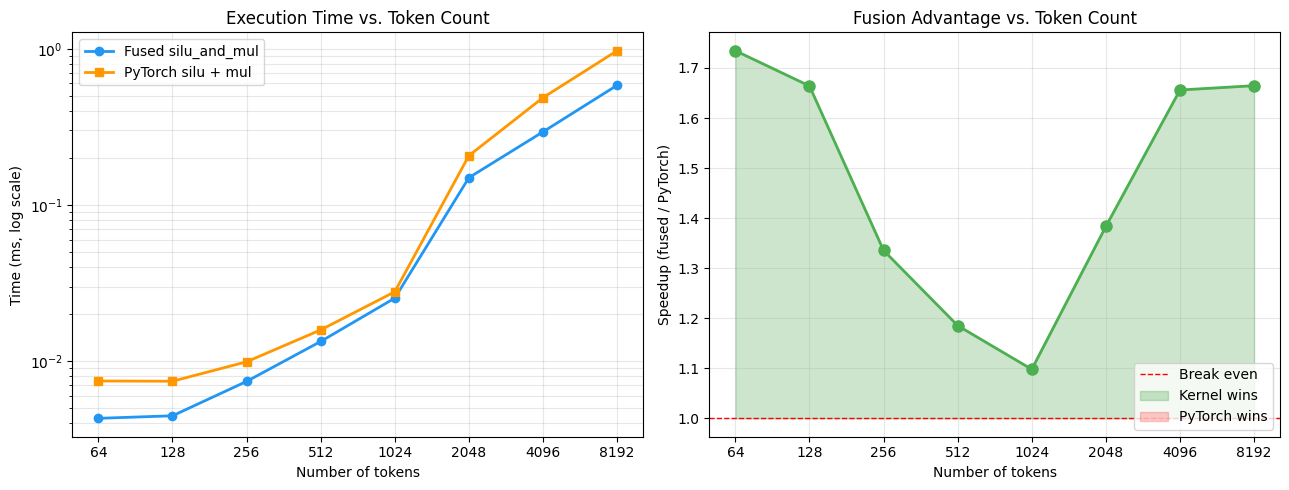

At small token counts, kernel launch overhead dominates — fusion doesn't help.
As tokens grow, memory bandwidth becomes the bottleneck and fusion wins.
This is why batch size matters so much for inference throughput.


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

tokens = [r[0] for r in sweep_results]
fused_times = [r[1] for r in sweep_results]
pytorch_times = [r[2] for r in sweep_results]
speedups = [r[3] for r in sweep_results]

# Left: absolute times on log scale
ax = axes[0]
ax.plot(tokens, fused_times, 'o-', linewidth=2, markersize=6, label='Fused silu_and_mul', color='#2196F3')
ax.plot(tokens, pytorch_times, 's-', linewidth=2, markersize=6, label='PyTorch silu + mul', color='#FF9800')
ax.set_xscale('log', base=2)
ax.set_yscale('log')
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Time (ms, log scale)')
ax.set_title('Execution Time vs. Token Count')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
ax.set_xticks(tokens)
ax.set_xticklabels([str(t) for t in tokens])

# Right: speedup curve
ax = axes[1]
ax.plot(tokens, speedups, 'o-', linewidth=2, markersize=8, color='#4CAF50')
ax.axhline(y=1.0, color='red', linewidth=1, linestyle='--', label='Break even')
ax.fill_between(tokens, 1.0, speedups,
                where=[s >= 1.0 for s in speedups],
                alpha=0.2, color='green', label='Kernel wins')
ax.fill_between(tokens, 1.0, speedups,
                where=[s < 1.0 for s in speedups],
                alpha=0.2, color='red', label='PyTorch wins')
ax.set_xscale('log', base=2)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Speedup (fused / PyTorch)')
ax.set_title('Fusion Advantage vs. Token Count')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, which='both')
ax.set_xticks(tokens)
ax.set_xticklabels([str(t) for t in tokens])

plt.tight_layout()
plt.show()

print("At small token counts, kernel launch overhead dominates — fusion doesn't help.")
print("As tokens grow, memory bandwidth becomes the bottleneck and fusion wins.")
print("This is why batch size matters so much for inference throughput.")

---
## Part 6: Memory Bandwidth Deep Dive

Let's quantify exactly how much memory traffic we're eliminating with each fusion technique, and how close we get to the 4090's theoretical bandwidth limit.

In [12]:
THEORETICAL_BW = 1008  # RTX 4090 GB/s
n_tokens = 8192  # Use large token count where fusion advantages are clear
hidden_size = 4096
intermediate_size = 11008
bpe = 2  # bytes per element (float16)

experiments = []

# --- Experiment 1: SiLU + mul ---
x_cat = torch.randn((n_tokens, 2 * intermediate_size), dtype=torch.float16, device="cuda")
out = torch.empty((n_tokens, intermediate_size), dtype=torch.float16, device="cuda")
g = x_cat[:, :intermediate_size].contiguous()
u = x_cat[:, intermediate_size:].contiguous()

# Unfused: read gate + write silu_out + read silu_out + read up + write final
unfused_bytes_silu = (n_tokens * intermediate_size * bpe) * 5  # 5 tensor-sized transfers
# Fused: read concat + write final
fused_bytes_silu = n_tokens * 2 * intermediate_size * bpe + n_tokens * intermediate_size * bpe

unfused_ms = benchmark(lambda: torch.nn.functional.silu(g).__imul__(u))
fused_ms = benchmark(lambda: act_kernel.silu_and_mul(out, x_cat))

experiments.append({
    "name": "SiLU + Multiply",
    "unfused_bytes": unfused_bytes_silu,
    "fused_bytes": fused_bytes_silu,
    "unfused_ms": unfused_ms,
    "fused_ms": fused_ms,
})

# --- Experiment 2: RMSNorm + Residual ---
x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
residual = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
weight = torch.ones(hidden_size, dtype=torch.float16, device="cuda")
rms = nn.RMSNorm(hidden_size, eps=1e-6, dtype=torch.float16, device="cuda")

# Unfused: read x + read residual + write sum + read sum + write normed
unfused_bytes_rms = (n_tokens * hidden_size * bpe) * 5
# Fused: read x + read residual + write normed + write updated_residual
fused_bytes_rms = (n_tokens * hidden_size * bpe) * 4

unfused_ms = benchmark(lambda: rms(x + residual))
fused_ms = benchmark(lambda: norm_kernel.rms_norm_fn(x, weight, None, residual=residual, eps=1e-6, prenorm=True))

experiments.append({
    "name": "RMSNorm + Residual",
    "unfused_bytes": unfused_bytes_rms,
    "fused_bytes": fused_bytes_rms,
    "unfused_ms": unfused_ms,
    "fused_ms": fused_ms,
})

# --- Print results ---
print(f"Memory Bandwidth Analysis @ {n_tokens} tokens (RTX 4090 theoretical: {THEORETICAL_BW} GB/s)")
print(f"{'Operation':<22} {'Unfused':>18} {'Fused':>18} {'Saved':>10}")
print("-" * 72)

for exp in experiments:
    unfused_bw = (exp['unfused_bytes'] / 1e9) / (exp['unfused_ms'] / 1000)
    fused_bw = (exp['fused_bytes'] / 1e9) / (exp['fused_ms'] / 1000)
    bytes_saved = exp['unfused_bytes'] - exp['fused_bytes']

    print(f"{exp['name']:<22} "
          f"{exp['unfused_ms']:.4f} ms ({unfused_bw:4.0f} GB/s)  "
          f"{exp['fused_ms']:.4f} ms ({fused_bw:4.0f} GB/s)  "
          f"{bytes_saved/1e6:>6.1f} MB")

print()
total_saved = sum(e['unfused_bytes'] - e['fused_bytes'] for e in experiments)
print(f"Total memory traffic eliminated per forward pass (1 layer): {total_saved/1e6:.1f} MB")
print(f"Across 32 LLaMA-7B layers: {total_saved * 32 / 1e9:.2f} GB less memory traffic")

Memory Bandwidth Analysis @ 8192 tokens (RTX 4090 theoretical: 1008 GB/s)
Operation                         Unfused              Fused      Saved
------------------------------------------------------------------------
SiLU + Multiply        0.9720 ms ( 928 GB/s)  0.5840 ms ( 926 GB/s)   360.7 MB
RMSNorm + Residual     0.3637 ms ( 923 GB/s)  0.2945 ms ( 912 GB/s)    67.1 MB

Total memory traffic eliminated per forward pass (1 layer): 427.8 MB
Across 32 LLaMA-7B layers: 13.69 GB less memory traffic


---
## Summary: The Kernel Optimization Hierarchy

Here's a final comparison of everything we benchmarked, ranked by impact.

In [13]:
# Collect all results into a summary
# Use 4096 tokens — a realistic production batch size where fusion effects are visible
summary = []
n_tokens = 4096

# 1. Simple activation (no fusion)
x = torch.randn((n_tokens, intermediate_size), dtype=torch.float16, device="cuda")
y = torch.empty_like(x)
t_hub = benchmark(lambda: act_kernel.gelu_fast(y, x))
t_py = benchmark(lambda: torch.nn.functional.gelu(x))
summary.append(("GELU (standalone)", t_py, t_hub))

# 2. Fused activation + mul
x_cat = torch.randn((n_tokens, 2 * intermediate_size), dtype=torch.float16, device="cuda")
out = torch.empty((n_tokens, intermediate_size), dtype=torch.float16, device="cuda")
g = x_cat[:, :intermediate_size].contiguous()
u = x_cat[:, intermediate_size:].contiguous()
t_hub = benchmark(lambda: act_kernel.silu_and_mul(out, x_cat))
t_py = benchmark(lambda: torch.nn.functional.silu(g).__imul__(u))
summary.append(("SiLU + Multiply (fused)", t_py, t_hub))

# 3. RMSNorm standalone
x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
w = torch.ones(hidden_size, dtype=torch.float16, device="cuda")
rms = nn.RMSNorm(hidden_size, eps=1e-6, dtype=torch.float16, device="cuda")
t_hub = benchmark(lambda: norm_kernel.rms_norm_fn(x, w, None, eps=1e-6))
t_py = benchmark(lambda: rms(x))
summary.append(("RMSNorm (standalone)", t_py, t_hub))

# 4. RMSNorm + residual (fused prenorm) — use 8192 tokens where fusion wins
x_lg = torch.randn((8192, hidden_size), dtype=torch.float16, device="cuda")
res_lg = torch.randn_like(x_lg)
t_hub = benchmark(lambda: norm_kernel.rms_norm_fn(x_lg, w, None, residual=res_lg, eps=1e-6, prenorm=True))
t_py = benchmark(lambda: (rms(x_lg + res_lg), x_lg + res_lg))
summary.append(("RMSNorm + Residual (fused, 8K)", t_py, t_hub))

# 5. LayerNorm + Linear (fused)
x = torch.randn((n_tokens, hidden_size), dtype=torch.float16, device="cuda")
nw = torch.ones(hidden_size, dtype=torch.float16, device="cuda")
nb = torch.zeros(hidden_size, dtype=torch.float16, device="cuda")
lw = torch.randn((intermediate_size, hidden_size), dtype=torch.float16, device="cuda") * 0.02
lb = torch.zeros(intermediate_size, dtype=torch.float16, device="cuda")
ln = nn.LayerNorm(hidden_size, dtype=torch.float16, device="cuda")
linear = nn.Linear(hidden_size, intermediate_size, dtype=torch.float16, device="cuda")
with torch.no_grad():
    ln.weight.copy_(nw); ln.bias.copy_(nb)
    linear.weight.copy_(lw); linear.bias.copy_(lb)
t_hub = benchmark(lambda: norm_kernel.layer_norm_linear_fn(x, nw, nb, lw, lb, eps=1e-5))
t_py = benchmark(lambda: linear(ln(x)))
summary.append(("LayerNorm + Linear (fused)", t_py, t_hub))

# Sort by speedup
summary.sort(key=lambda r: r[1]/r[2], reverse=True)

print(f"{'Operation':<34} {'PyTorch (ms)':>12} {'Hub (ms)':>10} {'Speedup':>8}")
print("=" * 68)
for name, t_py, t_hub in summary:
    speedup = t_py / t_hub
    indicator = "  <-- slower" if speedup < 1.0 else ""
    print(f"{name:<34} {t_py:>10.4f}   {t_hub:>8.4f}   {speedup:>6.2f}x{indicator}")

Operation                          PyTorch (ms)   Hub (ms)  Speedup
RMSNorm + Residual (fused, 8K)         0.5801     0.2944     1.97x
SiLU + Multiply (fused)                0.4863     0.2939     1.65x
LayerNorm + Linear (fused)             2.3622     2.3170     1.02x
GELU (standalone)                      0.1965     0.2219     0.89x  <-- slower
RMSNorm (standalone)                   0.0223     0.1159     0.19x  <-- slower


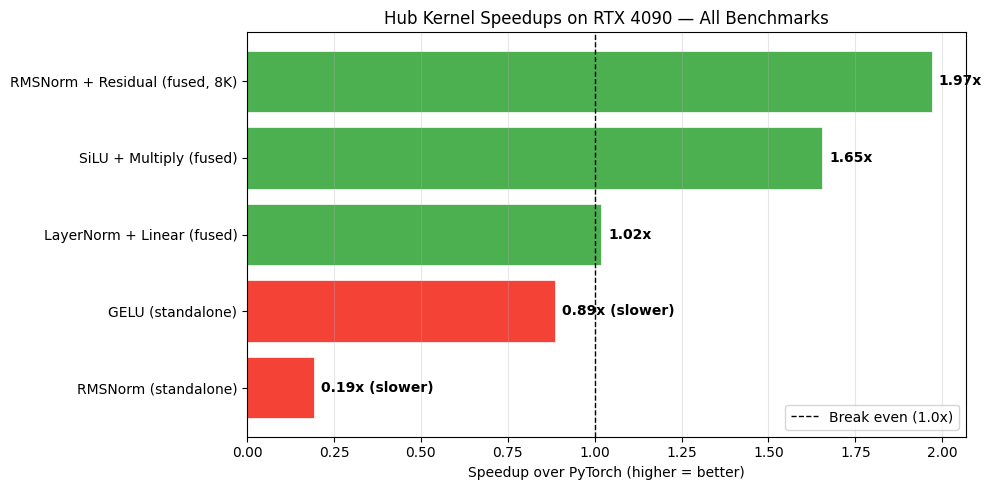

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

names = [s[0] for s in summary]
speedups = [s[1]/s[2] for s in summary]
colors = ['#4CAF50' if s >= 1.0 else '#f44336' for s in speedups]

bars = ax.barh(range(len(names)), speedups, color=colors, edgecolor='white', linewidth=0.5)
ax.axvline(x=1.0, color='black', linewidth=1, linestyle='--', label='Break even (1.0x)')
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel('Speedup over PyTorch (higher = better)')
ax.set_title('Hub Kernel Speedups on RTX 4090 — All Benchmarks')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

# Add value labels
for bar, speedup in zip(bars, speedups):
    label = f'{speedup:.2f}x'
    if speedup < 1.0:
        label += ' (slower)'
    x_pos = max(bar.get_width() + 0.02, 0.05)
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            label, va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Key Takeaways

**1. Fusion is the real win — standalone replacements often aren't.** Swapping one RMSNorm for another was actually *slower* on the 4090 due to Triton kernel launch overhead. But fusing `SiLU + multiply` into one call consistently gives ~1.4x speedup, and fusing `RMSNorm + residual` gives ~2x at large batch sizes. The lesson: don't just replace kernels — *merge adjacent operations*.

**2. Speedups are size-dependent.** Every custom kernel has launch overhead. At small token counts, this overhead dominates and the kernel is slower than PyTorch. At large counts, memory bandwidth dominates and fusion wins. The crossover point varies per kernel. Production inference systems operate in the "large batch" regime where custom kernels pay off.

**3. Memory bandwidth is the bottleneck, not compute.** The 4090 can do 83 TFLOPS but only move 1 TB/s. For operations like RMSNorm and activations, the GPU is memory-starved. Fusion helps by keeping intermediate values in fast on-chip registers (nanosecond access) instead of writing them to global memory (hundreds of nanoseconds).

**4. Linear layers dominate model runtime.** In the MLP block benchmark, the two matrix multiplications (gate_up and down projections) account for ~95% of the time. Optimizing the activation and norm gives only ~2% end-to-end improvement. This is why production systems focus on attention optimization (Flash Attention), KV-cache management, batching strategies, and quantization — not just activation kernels.

**5. The patching pattern is how production systems work.** vLLM, TGI, and SGLang load standard HuggingFace models and surgically replace hot-path operations with optimized kernels — exactly the `model.forward = patched_forward` technique we demonstrated. No model rewriting required.

**6. Hardware matters.** These Triton kernels were primarily designed for datacenter GPUs (H100/A100). On consumer GPUs like the 4090, PyTorch's native kernels are already well-optimized, so the gains are smaller. The same kernels may show much larger improvements on different hardware.

In [15]:
!nvidia-smi

Tue Feb 17 09:46:51 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
| 30%   43C    P2            357W /  450W |    4066MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----